# ***Image Forgery Detection using Recompression***


## About the dataset

## Authentic images:

1. Au_ani_00001.jpg
   Au: Authentic
   ani: animal category
2. Other categories: arc (architecture), art, cha (characters), ind (indoor), nat (nature), pla (plants), txt (texture)

## Tampering images

a. Spliced image

        Tp_D_CRN_S_N_cha00063_art00014_11818.jpg

- Tp: Tampering
- D: Different (means the tampered region was copied from the different image)
- Next 5 letters stand for the techniques they used to create the images. Unfortunately, I don't remember exactly.
- cha00063: the source image
- art00014: the target image
- 11818: tampered image ID

b. Copy-move images

        Tp_S_NRN_M_N_pla00020_pla00020_10988.jpg

- Tp: Tampering
- S: Same (means the tampered region was copied from the same image)
- And the rest is similar to case a.

If you use the groundtruth dataset for a scientific publication, please cite the following papers:

- CASIA dataset

        @inproceedings{Dong2013,
        doi = {10.1109/chinasip.2013.6625374},
        url = {https://doi.org/10.1109/chinasip.2013.6625374},
        year = {2013},
        month = jul,
        publisher = {{IEEE}},
        author = {Jing Dong and Wei Wang and Tieniu Tan},
        title = {{CASIA} Image Tampering Detection Evaluation Database},
        booktitle = {2013 {IEEE} China Summit and International Conference on Signal and Information Processing}
        }

- CASIA groundtruth dataset

       @article{pham2019hybrid,
       title={Hybrid Image-Retrieval Method for Image-Splicing Validation},
       author={Pham, Nam Thanh and Lee, Jong-Weon and Kwon, Goo-Rak and Park, Chun-Su},
       journal={Symmetry},
       volume={11},
       number={1},
       pages={83},
       year={2019},
       publisher={Multidisciplinary Digital Publishing Institute}
       }


In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import joblib
PATH = '../dataset/CASIA2/'
import tensorflow as tf


In [2]:

# PATH_TP='./dataset/CASIA2/Tp/'
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH+label))
    for img_file in os.listdir(PATH+label):
        img_lst.append(PATH+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,../dataset/CASIA2/Au/Au_ani_00001.jpg,Au
1,../dataset/CASIA2/Au/Au_ani_00002.jpg,Au
2,../dataset/CASIA2/Au/Au_ani_00003.jpg,Au
3,../dataset/CASIA2/Au/Au_ani_00004.jpg,Au
4,../dataset/CASIA2/Au/Au_ani_00005.jpg,Au


In [4]:
path_resaved = '../dataset/resaved/'


def difference(path):
    filename = path
    # print(path)
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    # print(resaved_name)
    resaved_name = path_resaved+resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=92)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    # diff
    return diff


In [5]:
from keras.utils.np_utils import to_categorical
from pylab import *
X = []
y = []

for index, row in df.iterrows():
    x = array(difference(row[0]).resize((128, 128))).flatten()/255.0
    X.append(x)
    if row[1] == 'Au':
        y.append(0)
    else:
        y.append(1)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = to_categorical(y, 2)


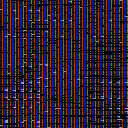

In [6]:
# x=difference(df['img'][9000]).resize((128, 128))
# # .flatten()/255.0
# x=array(x)
# print(x.shape)
# x.flatten().shape
# x
Image.fromarray(X[0], 'RGB')
# Image.fromarray(X[10].reshape((128,128,3)),'RGB')


### Train-Test Split


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20,  shuffle=True, stratify=Y)


In [8]:
print(X_train.shape, X_test.shape)
print(type(Y))


(10091, 128, 128, 3) (2523, 128, 128, 3)
<class 'numpy.ndarray'>


In [9]:
Y.shape

(12614, 2)

In [10]:
# extra 

from tensorflow.keras.utils import Sequence
import numpy as np


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


train_gen = DataGenerator(X_train, y_train, 32)
test_gen = DataGenerator(X_test, y_test, 32)



### Model Building


In [11]:
def build_model(activation='sigmoid'):

    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32,
              input_shape=[128, 128, 3], activation='relu'))

    # hidden layers
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(5, 5), activation='relu'))
    # pooling
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=2, padding='valid'))
    model.add(tf.keras.layers.Dropout(.50))
    # flatten
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.25))
    
    # model.add(tf.keras.layers.Dense(256, activation='relu'))
    # model.add(tf.keras.layers.Dropout(.50))

    # output layer
    model.add(tf.keras.layers.Dense(2, activation=activation))
    return model


In [12]:
# from sklearn.metrics import confusion_matrix

# y_pred = model.predict(X_test)

# # confusion_matrix(y_pred, y_test)
# y_pred


In [13]:
# y_pred = np.where(y_pred >= 0.5, 1, 0)


In [14]:
# y_pred = y_pred.astype('float32')
# y_pred = np.argmax(y_pred, axis=1)


In [15]:
# confusion_matrix(y_pred=y_pred, y_true=y_test.argmax(axis=1))


In [16]:
# plt.plot(range(1, 31), history['loss'])
# plt.plot(range(1, 31), history['val_loss'])
# plt.legend(['Training loss', 'Validation loss'])
# plt.title('Learning Curve')
# plt.xlabel('Epochs')
# plt.ylabel('loss')


In [25]:
softmax_adam = build_model('softmax')
softmax_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 115200)            0         
                                                      

In [18]:
X_train.shape

(10091, 128, 128, 3)

In [19]:
y_train.shape

(10091, 2)

In [26]:
# from sklearn.metrics import f1_score
from keras import metrics

adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
epoch = 30
batch_size = 10
cal1 = tf.keras.callbacks.ModelCheckpoint(save_best_only=True, filepath='softmax_adam.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)
# optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# softmax_adam.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
softmax_adam.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy', 'mse'])
history = softmax_adam.fit(train_gen, validation_data=test_gen,  epochs=epoch, callbacks=[cal1])
history = history.history 
    

Epoch 1/30
316/316 [==============================] - 22s 66ms/step - loss: 0.4141 - accuracy: 0.8189 - mse: 0.1392 - val_loss: 0.3237 - val_accuracy: 0.8767 - val_mse: 0.1014
Epoch 2/30
316/316 [==============================] - 21s 65ms/step - loss: 0.3229 - accuracy: 0.8663 - mse: 0.1079 - val_loss: 0.2758 - val_accuracy: 0.8827 - val_mse: 0.0912
Epoch 3/30
316/316 [==============================] - 20s 63ms/step - loss: 0.2382 - accuracy: 0.8950 - mse: 0.0816 - val_loss: 0.2769 - val_accuracy: 0.8827 - val_mse: 0.0918
Epoch 4/30
316/316 [==============================] - 21s 65ms/step - loss: 0.2062 - accuracy: 0.9077 - mse: 0.0701 - val_loss: 0.2103 - val_accuracy: 0.9100 - val_mse: 0.0724
Epoch 5/30
316/316 [==============================] - 20s 63ms/step - loss: 0.1963 - accuracy: 0.9094 - mse: 0.0671 - val_loss: 0.2905 - val_accuracy: 0.8839 - val_mse: 0.0888
Epoch 6/30
316/316 [==============================] - 20s 63ms/step - loss: 0.1717 - accuracy: 0.9197 - mse: 0.0586 - va

Text(0, 0.5, 'loss')

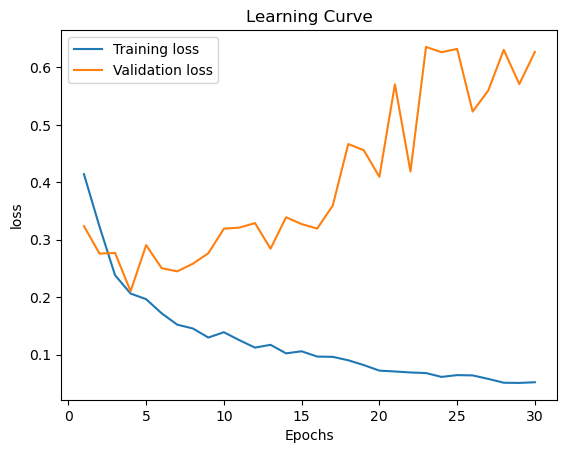

In [29]:
plt.plot(range(1, 31), history['loss'])
plt.plot(range(1, 31), history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

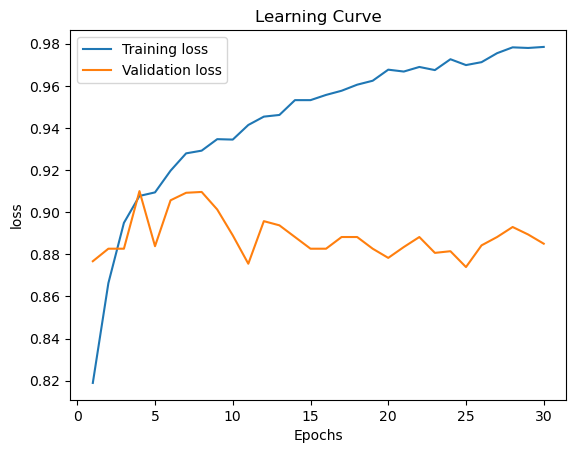

In [30]:
plt.plot(range(1, 31), history['accuracy'])
plt.plot(range(1,31), history['val_accuracy'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [31]:
softmax_adam = build_model('softmax')
softmax_adam.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 115200)            0         
                                                      

In [32]:


adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
epoch = 30
batch_size = 10
cal1 = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=True, filepath='softmax_rms.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)
optimizer = tf.keras.optimizers.RMSprop( rho=0.9, epsilon=1e-08, decay=0.0)
softmax_adam.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=['accuracy'])
# softmax_adam.compile(optimizer='adam', loss='binary_crossentropy',
#                      metrics=['accuracy', 'mse'])
history = softmax_adam.fit(
    train_gen, validation_data=test_gen,  epochs=epoch, callbacks=[cal1])
history = history.history


Epoch 1/30
316/316 [==============================] - 24s 75ms/step - loss: 0.4929 - accuracy: 0.7658 - val_loss: 0.3572 - val_accuracy: 0.8593
Epoch 2/30
316/316 [==============================] - 23s 73ms/step - loss: 0.3573 - accuracy: 0.8489 - val_loss: 0.2548 - val_accuracy: 0.8938
Epoch 3/30
316/316 [==============================] - 23s 74ms/step - loss: 0.2764 - accuracy: 0.8812 - val_loss: 0.2324 - val_accuracy: 0.9080
Epoch 4/30
316/316 [==============================] - 24s 75ms/step - loss: 0.2489 - accuracy: 0.8927 - val_loss: 0.2241 - val_accuracy: 0.9049
Epoch 5/30
316/316 [==============================] - 23s 72ms/step - loss: 0.2325 - accuracy: 0.8994 - val_loss: 0.2321 - val_accuracy: 0.9017
Epoch 6/30
316/316 [==============================] - 23s 72ms/step - loss: 0.2187 - accuracy: 0.9049 - val_loss: 0.2241 - val_accuracy: 0.9017
Epoch 7/30
316/316 [==============================] - 23s 72ms/step - loss: 0.2074 - accuracy: 0.9074 - val_loss: 0.2344 - val_accuracy:

Text(0, 0.5, 'loss')

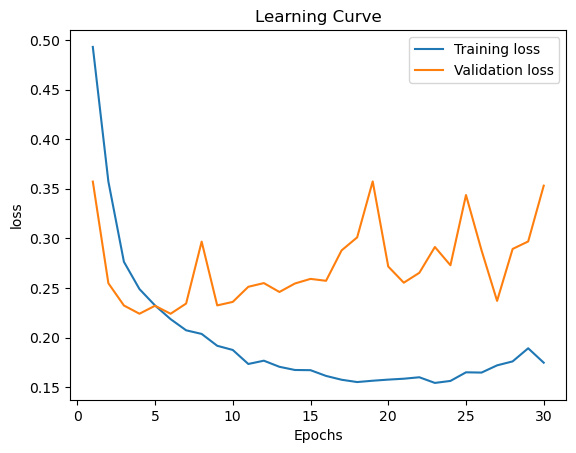

In [33]:
plt.plot(range(1, 31), history['loss'])
plt.plot(range(1, 31), history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

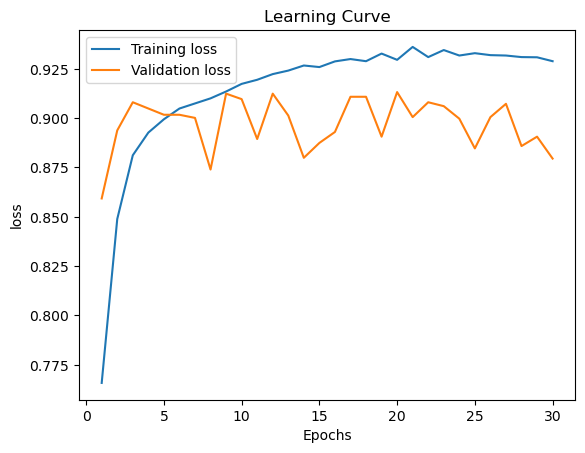

In [34]:
plt.plot(range(1, 31), history['accuracy'])
plt.plot(range(1, 31), history['val_accuracy'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')


In [23]:
from sklearn.metrics import recall_score, accuracy_score, precision_score

def print_score(acc, precision, recall):
    print(f"Recall score: {recall}")
    print(f"Precision score: {precision}")
    print(f"Accuracy score: {acc}")

In [24]:

y_pred = softmax_adam.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)
# print_score()
print_score(recall=recall_score(y_pred=y_pred, y_true=y_t), precision=precision_score(
    y_pred=y_pred, y_true=y_t), acc=accuracy_score(y_pred=y_pred, y_true=y_t))
confusion_matrix(y_pred=y_pred, y_true=y_t)


79/79 [==============================] - 1s 14ms/step
Recall score: 0.8887804878048781
Precision score: 0.852198316183349
Accuracy score: 0.8921918351169243


NameError: name 'confusion_matrix' is not defined

In [ ]:
from tensorflow.keras.models import load_model
model_sigmoid = load_model('./sigmoid_adam.h5')

y_pred = model_sigmoid.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)
# print_score()
print_score(recall=recall_score(y_pred=y_pred, y_true=y_t), precision=precision_score(
    y_pred=y_pred, y_true=y_t), acc=accuracy_score(y_pred=y_pred, y_true=y_t))
confusion_matrix(y_pred=y_pred, y_true=y_t)

79/79 [==============================] - 11s 142ms/step
Recall score: 0.9330143540669856
Precision score: 0.7933279088689992
Accuracy score: 0.8715814506539834


array([[1224,  254],
       [  70,  975]], dtype=int64)